In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
import os, glob, json
import config as cfg
from IPython.display import display
from ipywidgets import widgets, Layout
from module.cluster import VAE_Cluster
from module.vmt import VMT, TemplateD
from module.vae import GaussianKLLoss
from dataset import KKDayUser, seq_collate
from constant import Constants
from utils import get_fixed_temperature, get_losses
from sklearn.cluster import KMeans
import numpy as np
from tensorboardX import SummaryWriter
from utils import gradient_penalty, str2bool, chunks
from sklearn.manifold import SpectralEmbedding
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from shutil import copyfile
import pickle
import seaborn as sns
from collections import namedtuple

In [3]:
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [4]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

In [22]:
from dataset import TemPest, tempest_collate
valid_dataset = TemPest(args.cache_path, 'valid')
print(len(valid_dataset))
eval_dataloader = torch.utils.data.DataLoader(valid_dataset, num_workers=8,
                        collate_fn=tempest_collate, batch_size=32, shuffle=False, drop_last=True)

dataset/valid.pt
cache/tempest_word_word2idx.pkl
1761


### Lets Visualize template first

In [82]:
log_name = 'save/gan_tempest_hinge-latent-2-1-2020-07-18-03-11-04/'
checkpoint = 'checkpoint_36000.pt'

from module.vmt import VMT
with open(os.path.join(log_name, 'params.json'), 'r') as f:
    params = json.load(f)
args = Struct(**params)
id_mapping = torch.load(os.path.join(args.cache_path, 'id_mapping.pt'))
user_size = len(id_mapping['user2id'])
user_size = user_size
prod_size = len(id_mapping['prod2id'])
id2user = { value: key for key, value in id_mapping['user2id'].items() }

model = VMT(args.gen_embed_dim, args.vocab_size,
            enc_hidden_size=256, dec_hidden_size=256, tmp_category=args.tmp_cat_dim,
            tmp_latent_dim=args.tmp_latent_dim, desc_latent_dim=args.desc_latent_dim, user_latent_dim=args.user_latent_dim,
            biset=args.biset, user_embedding=True, user_size=user_size,
            max_seq_len=args.max_seq_len-1, gpu=True).cuda()
model.load_state_dict(torch.load(os.path.join(log_name,checkpoint))['model'])


<All keys matched successfully>

Generate examples

In [83]:
sentences, references = [], []
temp_latent = []; temp_outputs= []
with torch.no_grad():
    for batch in tqdm(eval_dataloader):
        src_inputs = batch['src']
        tmp = batch['tmt']
        inputs, target = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
        users = batch['users']
        empty_users = users == -1
        batch_size = len(empty_users)
        users_filled = users.detach()
        users_filled[empty_users] = torch.randint(0, user_size, ( int(empty_users.sum()),  ))

        if cfg.CUDA:
            src_inputs = src_inputs.cuda()
            target = target.cuda()
            tmp = tmp.cuda()
            inputs = inputs.cuda()
            users_filled = users_filled.cuda()

        desc_outputs, desc_latent, desc_mean, desc_std = model.encode_desc(src_inputs)
        tmp_outputs, tmp_latent = model.encode_tmp(tmp)
        for latent_ in tmp_latent:
            temp_latent.append(latent_.cpu().numpy().flatten())
        for latent_ in tmp_outputs:
            temp_outputs.append(latent_.cpu().numpy())
        user_embeddings = model.user_embedding( users_filled )
        _, output_title = model.decode(tmp_latent, desc_latent, user_embeddings, 
                desc_outputs, tmp_outputs,
                max_length=target.shape[1])

        for idx, sent_token in enumerate(batch['tgt'][:, 1:]):
            reference = []
            for token in sent_token:
                if token.item() == Constants.EOS:
                    break
                reference.append(valid_dataset.tokenizer.idx2word[token.item()] )
            references.append(''.join(reference))

            sent = output_title[idx]
            sentence = []
            for token in sent:
                if token.item() == Constants.EOS:
                    break
                sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
            sentences.append(''.join(sentence))

/home/theblackcat102/Documents/text-subgan/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [84]:
X, title = [], []
print(len(temp_latent))
for idx, latent in enumerate(temp_latent):
    X.append(latent)
    title.append(references[idx])
temp_outputs = np.array(temp_outputs)
title = np.array(title)
X = np.array(X)

1760


### Visualize categorical distribution of the first template latent

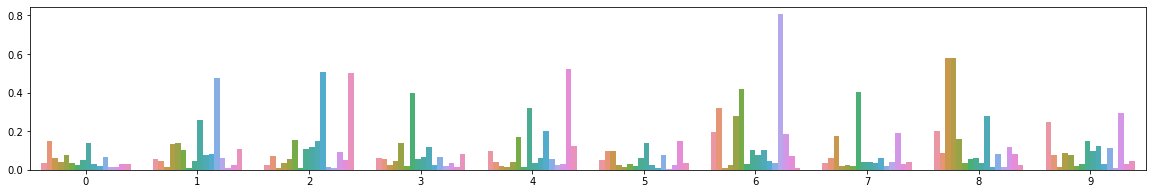

In [85]:
plt.rcParams["figure.figsize"] = (20,3)

data = {'y': [], 'bins': [], 'type': []}
for idx, latent in enumerate(X[0].reshape(args.tmp_latent_dim, args.tmp_cat_dim)):
    data['y'] += list(range(len(latent)))
    data['bins'] += list(latent)
    data['type'] += list([idx]*len(latent))
g = sns.barplot(x='y', y='bins', data=data, hue='type')
g.legend_.remove()

## Sample some latent as reference

In [86]:
with torch.no_grad():
    for idx, batch in enumerate(eval_dataloader):
        src_inputs = batch['src']
        tmp = batch['tmt']
        inputs, target = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
        users = batch['users']
        non_empty_users = users != -1
        if cfg.CUDA:
            src_inputs = src_inputs[non_empty_users].cuda()
            target = target[non_empty_users].cuda()
            tmp = tmp[non_empty_users].cuda()
            inputs = inputs[non_empty_users].cuda()
            users = users[non_empty_users].cuda()

        if non_empty_users.sum() > 0 and idx > 20:
            print('found')
            break

found


## Sample other latent as target

In [87]:
cnt = 0
with torch.no_grad():
    for batch in tqdm(eval_dataloader):
        cnt += 1
        users2 = batch['users']
        non_empty_users = users2 != -1
        if cfg.CUDA:
            users2 = users2[non_empty_users].cuda()
        if non_empty_users.sum() > 0 and cnt > 10:
            print('found')
            break

/home/theblackcat102/Documents/text-subgan/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


found


Generate reference title from reference latent

In [88]:
desc_outputs, desc_latent, desc_mean, desc_std = model.encode_desc(src_inputs)
tmp_outputs, tmp_latent = model.encode_tmp(tmp)
user_embeddings = model.user_embedding( users )
_, output_title = model.decode(tmp_latent, desc_latent, user_embeddings, 
        desc_outputs, tmp_outputs,
        max_length=target.shape[1])
original_sentences = []
original_pairs = []
for idx, sent in enumerate(output_title.cpu()):
    sentence = []
    for token in sent:
        if token.item() == Constants.EOS:
            break
        sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
    print("{:<40} | {:>}".format('user: '+ id2user[users[idx].item()], ''.join(sentence[:50]).strip(),  ))
    original_pairs.append("{:<40} | {:>}".format('user: '+ id2user[users[idx].item()], ''.join(sentence[:50]).strip(),  ))
    original_sentences.append(''.join(sentence[:50]).strip())

user: 4771cf1b-3f3c-43cf-aafc-ddea10f6a81f | 【陽明山一日】】藝、一、、、、、、
user: d750049d-8ebf-4c53-8432-d1d1ad4ec84e | 【必備】】】】】！！！選必備必備選
user: c830e28a-08d6-458b-bbea-7ed74069564c | 【品味鹿鳴推薦】】】澳門・瑞士翠玉雙人花園花園體驗體驗
user: 569b52de-a3ad-42f9-a4b4-b1bc3528118f | 【關西BTS票券】】周遊券KANSAIKANSAIPASS領取領取領取領取））
user: ae94e97a-de1f-4715-ac14-cd19f7ad3d0c | 【加拿大高一下樂園樂園寶樂園王國樂園主題
user: 023e0d76-aadd-4079-a4ba-9696b555a151 | 【金邊宗教城】】深度之
user: 207a38da-5898-4531-9d78-5ff8a52f78c5 | 【宿霧專屬】】國際、一、、、、、、、、、（出發出發））
user: 485eec45-3d5f-4cf7-aba8-0b4f5913ac78 | 【沙漠】遊輪】】日出、亞特蘭提斯極光旅
user: ca98e7ae-ab72-4935-b430-ff22d26fc84c | 【苗栗巴士一日滿足滿足三義鼻頭角（、旅、與與與與
user: cf201eb3-963b-475d-bb75-6a3d9188bde3 | 【大必大】動物園】皇宮藍TaoTao水族館門票門票
user: 1e3ca2dd-ad32-46f2-8039-4cc49f4b010f | 【24必備必備】隨隨上隨巴士觀光雙層巴士券


In [89]:
user2_embeddings = model.user_embedding( users2[:6,] )
_, output_title = model.decode(
        tmp_latent[:6],
        #control_latent[:6].cuda(), 
        desc_latent[:6], user2_embeddings[:6], 
        desc_outputs[:6], tmp_outputs[:6],
        max_length=target.shape[1])
for idx, (sent, origin_pair) in enumerate(zip(output_title, original_pairs)):
    sentence = []
    for token in sent:
        if token.item() == Constants.EOS:
            break
        sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
    print("old : "+origin_pair)
    print("new : {:<40} | {:>}\n".format('user: '+ id2user[users2[idx].item()] , ''.join(sentence[:50]).strip(), ))

old : user: 4771cf1b-3f3c-43cf-aafc-ddea10f6a81f | 【陽明山一日】】藝、一、、、、、、
new : user: 1cd1b500-4b31-4dfd-a489-6fd387d329e4 | 【陽明山一日】】藝、一、、、、、、

old : user: d750049d-8ebf-4c53-8432-d1d1ad4ec84e | 【必備】】】】】！！！選必備必備選
new : user: 9299189d-f939-4a8c-bafa-b13dcb1324ab | 【必備必備】】】超！！！選必備選選選

old : user: c830e28a-08d6-458b-bbea-7ed74069564c | 【品味鹿鳴推薦】】】澳門・瑞士翠玉雙人花園花園體驗體驗
new : user: a87c7122-805c-41cc-883f-2a408c9fd778 | 【品味鹿鳴】】】】Centara・瑞士翠玉＋花園花園體驗體驗

old : user: 569b52de-a3ad-42f9-a4b4-b1bc3528118f | 【關西BTS票券】】周遊券KANSAIKANSAIPASS領取領取領取領取））
new : user: f008da79-0242-489f-bd27-548518677ce9 | 【關西BTS女】】周遊券KANSAIKANSAIPASS領取領取領取領取））

old : user: ae94e97a-de1f-4715-ac14-cd19f7ad3d0c | 【加拿大高一下樂園樂園寶樂園王國樂園主題
new : user: c610cf57-b224-4e43-bcf9-3ec9d98c9e19 | 【新加坡高一下樂園樂園寶樂園王國世界主題

old : user: 023e0d76-aadd-4079-a4ba-9696b555a151 | 【金邊宗教城】】深度之
new : user: c13a7059-f867-4a01-b8d2-6702cb5d2be3 | 【金邊宗教城】】深度之



Can we randomly sample template latent for use? ( Only applicable for model without BiSET )

In [90]:
latent_dim = args.tmp_latent_dim
categorical_dim = args.tmp_cat_dim
M =  args.tmp_cat_dim * args.tmp_latent_dim
np_y = np.zeros((M, categorical_dim), dtype=np.float32)
np_y[range(M), np.random.choice(categorical_dim, M)] = 1
np_y = np.reshape(np_y, [ M // latent_dim, latent_dim, categorical_dim])[:6, :,:]

In [91]:
random_sample = torch.from_numpy(np_y).view(6, latent_dim * categorical_dim).cuda()
_, output_title = model.decode(
        random_sample,
        #control_latent[:6].cuda(), 
        desc_latent[:6], user_embeddings[:6], 
        desc_outputs[:6], tmp_outputs[:6],
        max_length=target.shape[1])
for idx, sent in enumerate(output_title):
    sentence = []
    for token in sent:
        if token.item() == Constants.EOS:
            break
        sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
    print("old : ",original_pairs[idx])
    print("new : {:<40} | {:>}\n".format('user: '+ id2user[users2[idx].item()] , ''.join(sentence[:50]).strip(), ))

old :  user: 4771cf1b-3f3c-43cf-aafc-ddea10f6a81f | 【陽明山一日】】藝、一、、、、、、
new : user: 1cd1b500-4b31-4dfd-a489-6fd387d329e4 | 【陽明山一日】】藝、一、、、、、、

old :  user: d750049d-8ebf-4c53-8432-d1d1ad4ec84e | 【必備】】】】】！！！選必備必備選
new : user: 9299189d-f939-4a8c-bafa-b13dcb1324ab | 【必備必備】】】超！必備！名勝必備選選

old :  user: c830e28a-08d6-458b-bbea-7ed74069564c | 【品味鹿鳴推薦】】】澳門・瑞士翠玉雙人花園花園體驗體驗
new : user: a87c7122-805c-41cc-883f-2a408c9fd778 | 【品味】推薦】】】Centara・瑞士翠玉二花園花園體驗

old :  user: 569b52de-a3ad-42f9-a4b4-b1bc3528118f | 【關西BTS票券】】周遊券KANSAIKANSAIPASS領取領取領取領取））
new : user: f008da79-0242-489f-bd27-548518677ce9 | 【關西BTS領取】關西周遊券KANSAITHRUPASS領取領取領取領取））

old :  user: ae94e97a-de1f-4715-ac14-cd19f7ad3d0c | 【加拿大高一下樂園樂園寶樂園王國樂園主題
new : user: c610cf57-b224-4e43-bcf9-3ec9d98c9e19 | 【聖淘沙島夜間】巴黎樂園寶樂園王國樂園主題

old :  user: 023e0d76-aadd-4079-a4ba-9696b555a151 | 【金邊宗教城】】深度之
new : user: c13a7059-f867-4a01-b8d2-6702cb5d2be3 | 【金邊宗教雙城】】深度之



Visualize template latent 

In [92]:
pca = PCA(n_components=2)
one_hot_x = [  torch.softmax(torch.from_numpy(row).reshape(10, 16), dim=-1).numpy()[1]  for row in X   ]
X_r = pca.fit_transform(X)
nbrs = SpectralClustering(n_clusters=3).fit(X_r)
y = nbrs.labels_
print(set(y))

{0, 1, 2}


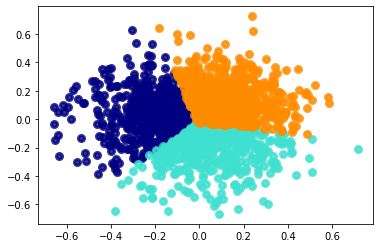

In [93]:
plt.rcParams["figure.figsize"] = (6,4)
plt.figure()

colors = ['navy', 'turquoise', 'darkorange']
target_names = list(range(len(colors)))
lw = 3
for color, i, target_name in zip(colors, list(range(len(target_names))), target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)

In [94]:
non_bracket_label = 2
start_idx = 12
no_bracket_latent = X[y==non_bracket_label][start_idx:start_idx+6]
no_bracket_latent_out = temp_outputs[y==non_bracket_label][start_idx:start_idx+6]
templates = title[y==non_bracket_label][start_idx:start_idx+6]

output_titles = []

for idx, (_latent, _latent_output) in enumerate(zip(no_bracket_latent, temp_outputs)):
    _latent = torch.from_numpy(_latent).view(1, latent_dim * categorical_dim).cuda()
    _latent_output = torch.from_numpy(_latent_output).unsqueeze(0).cuda()
    _, output_title = model.decode(
            _latent,
            desc_latent[[idx]], user2_embeddings[[idx]], 
            desc_outputs[[idx]], _latent_output,
            max_length=target.shape[1])
    output_titles.append(output_title.cpu())

output_titles = torch.cat(output_titles)
for idx, sent in enumerate(output_titles):
    sentence = []
    for token in sent:
        if token.item() == Constants.EOS:
            break
        sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
    print('target template   %s' % templates[idx])
    print('origin gen title %s ' % original_sentences[idx])
    print('new gen title    %s\n' % ''.join(sentence[:50]).strip())
#     print("{:<40} | {:>}".format('user: '+ id2user[users2[idx].item()] , ''.join(sentence[:50]).strip(), ))

target template   日月潭山光水色豐富一日遊
origin gen title 【陽明山一日】】藝、一、、、、、、 
new gen title    【陽明山一日】】藝、一、、、、、、遊

target template   【七島跳島日落遊】喀比必去浪漫之旅
origin gen title 【必備】】】】】！！！選必備必備選 
new gen title    【超必備】】】】皇帝島！！選必備選選

target template   波爾圖精選徒步遊
origin gen title 【品味鹿鳴推薦】】】澳門・瑞士翠玉雙人花園花園體驗體驗 
new gen title    【品味鹿鳴推薦】】】澳門・Farm翠玉＋花園花園體驗體驗體驗

target template   【瘋狂飛瀑群】桃園小烏來。</UNK>溪溯溪
origin gen title 【關西BTS票券】】周遊券KANSAIKANSAIPASS領取領取領取領取）） 
new gen title    【關西BTS票券】】周遊券KANSAIKANSAIPASS領取領取領取領取））

target template   【2016</UNK>攝影】可可</UNK>．柴達木．</UNK>．越野9日行攝之旅（專業攝影師帶隊）
origin gen title 【加拿大高一下樂園樂園寶樂園王國樂園主題 
new gen title    【加拿大高】樂園樂園寶樂園王國世界主題

target template   紐倫堡舊城與全</UNK></UNK>會場徒步行
origin gen title 【金邊宗教城】】深度之 
new gen title    【金邊宗教雙城】】深度之



In [95]:
print(title[y==0][:60])

['【Disneyland】美國加州迪士尼樂園門票（電子一日券）'
 '【熱門景點包車一日遊】石門水庫、鎮瀾宮、台中麗寶Outlet（台北出發、台中結束）' '【龍尾灣生態體驗】搭竹筏＋抓螃蟹＋做蠟染（含馬來午餐）'
 '【仙本那紅樹林】探索長鼻猴與螢火蟲半日遊' '墾丁高雄零阻礙輕鬆包車接駁' '組合：在</UNK>和觀光游到伊瓜蘇瀑布'
 '【澳門美獅美高梅酒店】</UNK>・JaniceWongMGM午餐套餐/下午茶套餐' '【新加坡郊野深度遊】烏敏島紅樹林獨木舟探險'
 '【Discovery探索基地】' '【台東包車半日遊】快速遊台東熱門景點' '【真愛宣言，致深愛電影的你】韓國</UNK>電影博物館'
 '【騎單車遊曼谷】早安曼谷單車之旅' '3天2夜親子遊' '【馬來西亞．動物探索之旅】大象保育中心與鹿島公園'
 '【到海底看珊瑚礁】墾丁後壁湖半潛艇航程' '【越南版紫禁城】順化古城半日遊' '【東京文化體驗】武士博物館・體驗正統武士道精神'
 '【360度全</UNK>視覺體驗】珠海長</UNK>琴島劇院' '巴哈吉普車遊覽聖地亞哥洛斯卡沃斯：驅動器或騎'
 '妓院、美食與豪飲:聖地亞哥瓦斯</UNK>徒步遊' '南加州必遊聖地亞哥海洋世界奇趣之旅'
 '【超值體驗】TOKYOSKYTREE東京晴空塔＋30樓浪漫法式午餐/晚餐' '在墨西哥城的墨西哥民俗芭蕾' '坎昆出發，奇琴伊察延長全日遊'
 '【東京自助必備】日光周遊券－東武鐵道' '【SUP熱門新玩法】台北金山絕美燭台雙嶼SUP體驗' '葡萄牧場：瓦豪河谷酒莊自行車之旅'
 '聖伊格納西奧與萬達地雷：從伊瓜蘇港旅遊' '【太陽的後裔拍攝地】希臘</UNK>半日遊' '豪華</UNK>馬斯美食之旅從麥德林'
 '【墾丁陸上活動】南灣草地雙人飛球體驗' '芝加哥歡迎之旅：私有遊覽與本地' '【7-16座專車】大叻-美奈單程租車'
 '【九州巴士一日遊】國寶</UNK>神社、</UNK>溫泉（熊本出發）' '【首爾人氣美食】大砲燉雞大學路店'
 '【江戶時代富豪體驗】東京隅田川屋形船巡航（享用豪華餐點＆無限暢飲）' '從福塔萊薩：8小時一日遊摩洛布蘭科'
 '【伊豆群島】東京秘境八丈島2小時浮潛體驗' '【荷蘭最美小鎮】羊角村小團悠閒一日遊阿姆斯特丹出發)' '晚餐遊船、埃菲爾鐵塔以及紅磨坊香檳'


In [96]:
print(title[y==1][:60])

['漢堡喜劇之旅' '倫敦和哈利·波特場景私人半日遊' '【東京夜景】六本木之丘展望台門票（TokyoCityView）森美術館'
 '【中文導覽】馬來西亞機場市區優質接送（含WiFi熱點）' '【東京賞櫻推薦】隅田川賞櫻遊船票（附賞花便當或點心）'
 '【胡志明市特色一日遊】古芝地道、胡志明市區觀光導覽' '《沖繩景點通行票》精選熱門景點＋</UNK>水族館' '卡門浮潛和廢墟探險'
 "阿姆斯特丹：A'DAM瞭望臺和OvertheEdge鞦韆票" '【北投人氣溫泉】北投麗禧溫泉雙人湯屋＋雙人下午茶'
 '【艾菲爾鐵塔快速入場】巴黎艾菲爾鐵塔快速入場與塞納河遊船' '【普吉唯一友善大象營】親密互動半日體驗'
 '【超值沙巴跳島】沙比島和馬穆迪島一日遊' '米蘭：斯卡拉博物館與劇院旅遊' '【首爾人氣美食餐廳】</UNK>家黑豬肉專賣店'
 '自採超甜草莓・螃蟹吃到飽＆滑雪場玩雪東京出發)' '【SPA</UNK>】大邱以利</UNK>入場券（上</UNK>）'
 '女性限定一人行！一次遊走日本香川、岡山、德島三縣市美術館充滿藝術氣質二日遊！' '柏林景點和亮點：3.5小時自行車旅遊'
 '【小團划算】桃園機場臺北市區接機服務（七人座）' '【日本傳統文化】搭屋形船觀賞長</UNK>魚・泡溫泉品嚐</UNK>料理大阪出發)'
 '【巴黎夜未眠】夜間觀光巴士城市導覽、紅磨坊歌舞秀' '黃石國家公園老忠實噴泉與野生動物一日遊' '</UNK>海縱走生態行'
 '攀登雪梨海港大橋' '台北車站精緻旅舍：STARHostel3-4晚超值套餐（免費送台北單車導覽！）'
 '【跟著專業導遊輕鬆</UNK>】360大嶼山海陸導賞團' '【專業嚮導玉山三日遊】玉山．相約東北亞最高峰'
 '【沖繩自駕租車】獨家限定優惠・7人座WB級・淡季' '【日本阿爾卑斯X童話北陸】立山黑部、白川鄉合掌村、兼六園、高山古街、松本城五天四夜多日遊'
 '【乘船遊小金門秘境】船遊戰地史蹟烈嶼7島（</UNK>碼頭出發）' '【大城遊船一日遊】沿著昭披耶河欣賞世界遺產'
 '【苗栗包車一日遊】</UNK>子母隧道、</UNK>車站、蘇維拉莊園、落羽松莊園（台北出發）'
 '【幸福小資GO】經典建築探訪洛城市中心深度之旅' '【法國巴黎】塞納河遊輪上享受法式料理'
 '【出訪捷克古城】</UNK></UN

In [97]:
tmp_latent = X[y==1].mean(axis=0)

In [39]:
control_latent = torch.stack([torch.from_numpy(tmp_latent)]*10)

In [29]:
print(title[y==0][:10])

['【Disneyland】美國加州迪士尼樂園門票（電子一日券）' '【東京夜景】六本木之丘展望台門票（TokyoCityView）森美術館'
 '【龍尾灣生態體驗】搭竹筏＋抓螃蟹＋做蠟染（含馬來午餐）' '【仙本那紅樹林】探索長鼻猴與螢火蟲半日遊'
 '【東京賞櫻推薦】隅田川賞櫻遊船票（附賞花便當或點心）' '【胡志明市特色一日遊】古芝地道、胡志明市區觀光導覽'
 '【澳門美獅美高梅酒店】</UNK>・JaniceWongMGM午餐套餐/下午茶套餐' '【普吉唯一友善大象營】親密互動半日體驗'
 '【日本傳統文化】搭屋形船觀賞長</UNK>魚・泡溫泉品嚐</UNK>料理大阪出發)' '【到海底看珊瑚礁】墾丁後壁湖半潛艇航程']


In [44]:
print(title[y==2][:10])

['【柬埔寨最受矚目劇團】法爾，柬埔寨馬戲團Phare,theCambodiaCircus' '雅典城市通票：免費入場和免費遊覽'
 '伊瓜蘇生物中心參觀' '在日落時分騎馬，體驗西部荒原的牛仔生活' '斯德哥爾摩隨上隨下觀光巴士與小船旅遊'
 '聖薩爾瓦多：5小時中轉城市與火山之旅' '曼哈頓島豪華直升機旅遊' '波士頓的歷史之路®徒步遊' '布魯塞爾：布魯日一日旅遊連4小時導覽徒步遊'
 '柏林：1小時馬車夜遊柏林']


In [31]:
print(title[y==3][:10])

['【熱門景點包車一日遊】石門水庫、鎮瀾宮、台中麗寶Outlet（台北出發、台中結束）' '【中文導覽】馬來西亞機場市區優質接送（含WiFi熱點）'
 '【名古屋出發一人成行】閃耀冬季！名花之里．冬季霓虹燈秀，還有午餐甜點吃到飽' '【超值沙巴跳島】沙比島和馬穆迪島一日遊'
 '【經典花蓮必遊】太魯閣奇景拼車一日遊（保證有位）' '【熱門景點包車一日遊】鶯歌老街、新豐紅樹林、彩虹眷村、秋紅谷（台北出發）'
 '自採超甜草莓・螃蟹吃到飽＆滑雪場玩雪東京出發)' '女性限定一人行！一次遊走日本香川、岡山、德島三縣市美術館充滿藝術氣質二日遊！'
 '【小團划算】桃園機場臺北市區接機服務（七人座）' '【乘船遊小金門秘境】船遊戰地史蹟烈嶼7島（</UNK>碼頭出發）']


# Unrelated old code

In [61]:
assert os.path.exists(os.path.join(log_name, 'vmt.py')) == True
print(os.path.join(log_name, checkpoint_name))
assert os.path.exists(os.path.join(log_name, checkpoint_name)) == True

copyfile(os.path.join(log_name, 'vmt.py'), 'module/temp_vmt.py')
checkpoint = torch.load(os.path.join(log_name, checkpoint_name))

from module.temp_vmt import VMT, TemplateD

# checkpoint should contain model state dict,
with open(os.path.join(log_name, 'params.json'), 'r') as f:
    params = json.load(f)
args = Struct(**params)
dataset =  KKDayUser(-1, 'data/kkday_dataset/user_data', 
            'data/kkday_dataset/matrix_factorized_64.pkl',
            prefix='item_graph', embedding=None, max_length=args.max_seq_len, force_fix_len=args.grad_penalty or args.full_text, 
            token_level=args.tokenize, is_train=True)
dataloader = torch.utils.data.DataLoader(dataset, num_workers=4,
                collate_fn=seq_collate, batch_size=64, shuffle=True)
model = VMT(args.gen_embed_dim, dataset.vocab_size,
            enc_hidden_size=128, dec_hidden_size=128, tmp_category=args.tmp_cat_dim,
            tmp_latent_dim=args.tmp_latent_dim, desc_latent_dim=args.desc_latent_dim, user_latent_dim=args.user_latent_dim,
            biset=args.biset,
            max_seq_len=args.max_seq_len-1, gpu=True)

C = VAE_Cluster(64, 64, k_bins=10, output_embed_dim=args.user_latent_dim)

model.load_state_dict(checkpoint['model'])
model = model.cuda().eval()
C = C.cuda().eval()
print(len(dataloader))

save/temp_temp_rec_vae_gan_biset-2020-05-15-16-34-59/amp_checkpoint_80000.pt
3486


In [57]:
template_reference = {}
size = 15000

for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    src_inputs = batch['src']
    tmp = batch['tmp']
    items, users = batch['items'], batch['users']
    inputs, target1 = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
    references = []
    if True:
        inputs, items, users = inputs.cuda(), items.cuda(), users.cuda()
        src_inputs = src_inputs.cuda()
        inputs = inputs.cuda()
        target1 = target1.cuda()
        tmp = tmp.cuda()

    batch_size = src_inputs.shape[0]
#     logits, embed = self.C(items, users)
    desc_outputs, desc_latent, _, _ = model.encode_desc(src_inputs)
    tmp_outputs, tmp_latent = model.encode_tmp(tmp)
#     _, output_title = self.model.decode(tmp_latent, desc_latent, embed,
#             desc_outputs, tmp_outputs,
#             max_length=self.args.max_seq_len)

    # output_title = torch.argmax(output_logits, dim=-1)
    for idx, sent_token in enumerate(batch['tgt'][:, 1:]):
        reference = []
        for token in sent_token:
            if token.item() == Constants.EOS:
                break
            reference.append(dataset.idx2word[token.item()] )
        references.append(reference)
    
    for idx, sent in enumerate(references):
        template_reference[' '.join(sent)] = {
            'tmp': tmp_latent[idx].detach().cpu().numpy(),
            'tmp_outputs': tmp_outputs[idx].detach().cpu(),
            'desc_latent': desc_latent[idx].detach().cpu(),
            'desc_outputs': desc_outputs[idx].detach().cpu(),
        }


/home/theblackcat102/Documents/text-subgan/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


KeyboardInterrupt: 

In [80]:
from tokenizer import CharTokenizer, WordTokenizer
tokenizers = WordTokenizer()

def generate_text(description, template, user, item):
    with torch.no_grad():
        desc = torch.from_numpy(tokenizers.encode(description)).long().cuda()
        tgt = torch.from_numpy(tokenizers.encode(template)).long().cuda()

        user = torch.from_numpy(user).float().cuda().unsqueeze(0)
        item = torch.from_numpy(item).float().cuda().unsqueeze(0)

        tmp = tgt.unsqueeze(0)[:, :-1]
        src_inputs = desc.unsqueeze(0)
        logits, embed = C(item, user)
        desc_outputs, desc_latent, _, _ = model.encode_desc(src_inputs)
        tmp_outputs, tmp_latent = model.encode_tmp(tmp)
        _, output_title = model.decode(tmp_latent, desc_latent, embed,
                desc_outputs, tmp_outputs,
                max_length=64)

        sentence = []
        for token in output_title[0]:
            if token.item() == Constants.EOS:
                break
            sentence.append(  dataset.idx2word[token.item()])
        return ' '.join(sentence)

In [81]:
log_name = 'save/temp_rec_vae_gan_temp_rand_sample-2020-05-17-12-46-38/'
# log_name = 'save/temp_rec_vae_gan_biset_temp_rand_sample-2020-05-15-03-24-22/'
iteration = 100000
K_BINS = 20
checkpoint_name = 'amp_checkpoint_{}.pt'.format(iteration)
assert os.path.exists(os.path.join(log_name, 'vmt.py')) == True
print(os.path.join(log_name, checkpoint_name))
assert os.path.exists(os.path.join(log_name, checkpoint_name)) == True

copyfile(os.path.join(log_name, 'vmt.py'), 'module/temp_vmt.py')


AssertionError: 

In [ ]:
from module.temp_vmt import VMT, TemplateD
checkpoint = torch.load(os.path.join(log_name, checkpoint_name))
# checkpoint should contain model state dict,
with open(os.path.join(log_name, 'params.json'), 'r') as f:
    params = json.load(f)

args = Struct(**params)

dataset =  KKDayUser(-1, 'data/kkday_dataset/user_data', 
            'data/kkday_dataset/matrix_factorized_64.pkl',
            prefix='item_graph', embedding=None, max_length=args.max_seq_len, force_fix_len=args.grad_penalty or args.full_text, 
            token_level=args.tokenize, is_train=True)
dataloader = torch.utils.data.DataLoader(dataset, num_workers=4,
                collate_fn=seq_collate, batch_size=64, shuffle=True)

model = VMT(args.gen_embed_dim, dataset.vocab_size,
            enc_hidden_size=128, dec_hidden_size=128, tmp_category=args.tmp_cat_dim,
            tmp_latent_dim=args.tmp_latent_dim, desc_latent_dim=args.desc_latent_dim, user_latent_dim=args.user_latent_dim,
            biset=args.biset,
            max_seq_len=args.max_seq_len-1, gpu=True)

C = VAE_Cluster(64, 64, k_bins=10, output_embed_dim=args.user_latent_dim)

model.load_state_dict(checkpoint['model'])
model = model.cuda().eval()
C = C.cuda().eval()

In [ ]:
template_reference = {}
size = 15000

for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    src_inputs = batch['src']
    tmp = batch['tmp']
    items, users = batch['items'], batch['users']
    inputs, target1 = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
    references = []
    if True:
        inputs, items, users = inputs.cuda(), items.cuda(), users.cuda()
        src_inputs = src_inputs.cuda()
        inputs = inputs.cuda()
        target1 = target1.cuda()
        tmp = tmp.cuda()

    batch_size = src_inputs.shape[0]
    desc_outputs, desc_latent, _, _ = model.encode_desc(src_inputs)
    _, tmp_latent = model.encode_tmp(tmp)
    # output_title = torch.argmax(output_logits, dim=-1)
    for idx, sent_token in enumerate(batch['tgt'][:, 1:]):
        reference = []
        for token in sent_token:
            if token.item() == Constants.EOS:
                break
            reference.append(dataset.idx2word[token.item()] )
        references.append(reference)

    for idx, sent in enumerate(references):
        template_reference[' '.join(sent)] = {
            'tmp': tmp_latent[idx].detach().cpu().numpy(),
#             'tmp_outputs': tmp_outputs[idx],
            'desc_latent': desc_latent[idx].detach().cpu(),
            'desc_outputs': desc_outputs[idx].detach().cpu(),
        }


In [ ]:
X, title = [], []
print(len(template_reference))
for key, latent in template_reference.items():
    X.append(latent['tmp'])
    title.append(key)
title = np.array(title)

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

nbrs = SpectralClustering(n_clusters=6).fit(X_r)

y = nbrs.labels_
print(set(y))

In [ ]:
plt.figure()
target_names = [0,1,2,3,4, 5]

colors = ['navy', 'turquoise', 'darkorange','red','black', 'green']
lw = 2

for color, i, target_name in zip(colors, list(range(len(target_names))), target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)

In [ ]:
for target_name in target_names:
    print(target_name, len(title[y==target_name]))
    print('\n'.join(title[y==target_name][:10]))
    print('')